In [1]:
# This course just to give you some intuition about model complexity and overfitting 
import sys
sys.path.append("../")

import d2l
from d2l import Accumulator
from d2l import Animator
from mxnet import autograd, nd, gluon
from mxnet.gluon import nn


In [2]:
'''
    1. Generating Data Sets
'''
# Maximum degree of the polynomial
maxdegree = 20
n_train, n_test = 100, 100
# Allocate lots of empty space
true_w = nd.zeros(maxdegree)
true_w[0: 4] = nd.array([5, 1.2, -3.4, 5.6])

features = nd.random.normal(shape=(n_train + n_test, 1))
features = nd.random.shuffle(features)
poly_features = nd.power(features, nd.arange(maxdegree).reshape(shape=(1, -1)))
poly_features = poly_features / (nd.gamma(nd.arange(maxdegree) + 1).reshape(shape=(1, -1)))

labels = nd.dot(poly_features, true_w)
labels += nd.random.normal(scale= 0.1, shape=labels.shape)

weight: [[ 5.0037365  1.1830539 -3.396482   5.5797896]]


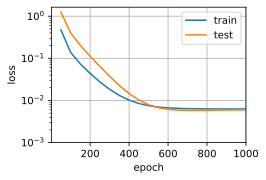

In [28]:
''' 
    2. Defining, Training and Testing Model
'''
def evaluate_loss(net , data_iter, loss):
    metric = Accumulator.Accumulator(2)
    for X, y in data_iter:
        metric.add(loss(net(X), y).sum().asscalar(), y.size)
    return metric[0]/metric[1]


def load_array(data_array, batch_size, is_train=True):
    dataset = gluon.data.ArrayDataset(*data_array)
    return gluon.data.DataLoader(dataset, batch_size, shuffle=is_train)


def train(train_features, test_features, train_labels, test_labels, num_epoch = 1000):
    loss = gluon.loss.L2Loss()
    net = nn.Sequential()
    net.add(nn.Dense(1, use_bias=False))
    net.initialize()
    batch_size = min(10, train_labels.shape[0])
    
    train_iter = load_array((train_features, train_labels), batch_size)
    test_iter = load_array((test_features, test_labels), batch_size)
    
    trainer = gluon.Trainer(net.collect_params(), 'sgd', {'learning_rate': 0.01})
    
    animator = Animator.Animator(xlabel='epoch', ylabel='loss', yscale='log',
                        xlim = [1, num_epoch],
                        ylim=[1e-3, 0], 
                        legend=['train', 'test'])
    
    for epoch in range(1, num_epoch + 1):
        d2l.train_epoch_ch3(net, train_iter, loss, trainer)
        if epoch % 50 == 0:
            animator.add(epoch, (evaluate_loss(net, train_iter, loss), evaluate_loss(net, test_iter, loss)))
    print('weight:', net[0].weight.data().asnumpy())  

'''
    3. Pick the first four dimensions
'''
train(poly_features[: n_train, 0: 4], poly_features[n_train:, 0: 4], labels[:n_train], labels[n_train:])


weight: [[ 5.392862   3.4813814 -4.2621503]]


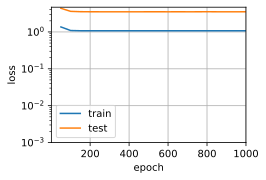

In [29]:
'''
    4. Linear Function Fitting(Underfitting)
'''
train(poly_features[: n_train, 0: 3], poly_features[n_train:, 0: 3],
      labels[:n_train], labels[n_train:])

weight: [[ 4.922735    1.3467008  -2.9593809   4.960897   -1.2331883   1.1866201
  -0.26649785  0.17721686  0.02791738  0.06028436  0.04174037 -0.01199332
   0.00961996 -0.05039219 -0.01299653 -0.06534877 -0.06031662  0.06756049
   0.02764003 -0.0177393 ]]


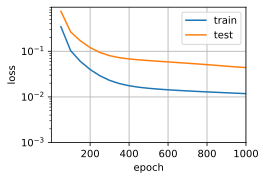

In [30]:
'''
    5. Overfitting
'''
n_subset = 100  # Subset of data to train on
n_degree = 20   # Degree of polynomials
train(poly_features[1:n_subset, 0:n_degree],
      poly_features[n_train:, 0:n_degree], labels[1:n_subset],
      labels[n_train:])